## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6007173231120018108
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16557229200605970586
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13878732296762228442
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15933712095115114255
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

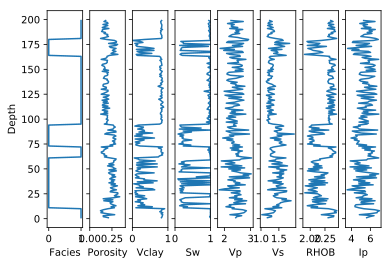

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


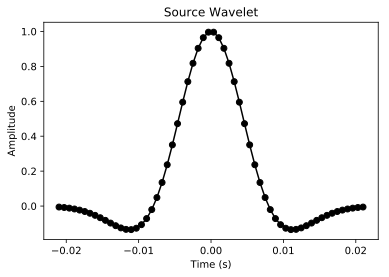

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [8]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

In [9]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


In [10]:
# Forward modeling results (Seismic gathers)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


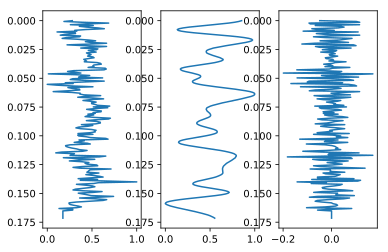

In [10]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [11]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.backend import manual_variable_initialization 
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [12]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))


# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]
petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
petromodel = petromodel.reshape((num_examples, 3, ndepth))

# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)

# Split data into train and test set - petro model
X_train_petro, X_test_petro, Y_train_petro, Y_test_petro = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            petromodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train_petro = np.expand_dims(X_train_petro, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test_petro = np.expand_dims(X_test_petro, axis=3)

print ("number of training examples petromodel = " + str(X_train_petro.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples petromodel = " + str(X_test_petro.shape[0]))
print ("X_train_petromodel shape: " + str(X_train_petro.shape))
print ("Y_train_petromodel shape: " + str(Y_train_petro.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test_petromodel shape: " + str(X_test_petro.shape))
print ("Y_test_petromodel shape: " + str(Y_test_petro.shape))

number of training examples petromodel = 2000
number of test examples petromodel = 500
X_train_petromodel shape: (2000, 7, 246, 1)
Y_train_petromodel shape: (2000, 3, 199)
X_test_petromodel shape: (500, 7, 246, 1)
Y_test_petromodel shape: (500, 3, 199)


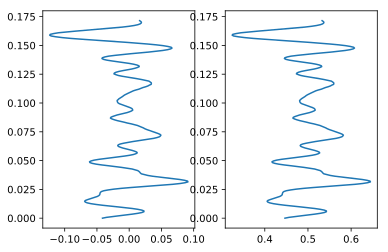

In [13]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [21]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility


def petronet(input_shape):
    """
    Implementation of the PetroNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(40, (1, 10), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(10, (1, 10), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(10, (1, 10), strides=(1, 1), name='conv2',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool2')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 10), strides=(1, 1), name='conv3',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn3')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool3')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*3, name='fc1')(X)
    X = Activation('sigmoid')(X)
    
    X = Reshape((3, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='PetroModel')

    return model
    ### END CODE HERE ###

In [22]:
# Create the model
PetroModel = petronet(X_train_petro.shape[1:])

In [23]:
# Summary and plot of the model

PetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 7, 237, 40)        440       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 7, 237, 40)        160       
_________________________________________________________________
activation_6 (Activation)    (None, 7, 237, 40)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 6, 236, 40)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 6, 227, 10)        4010      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 6, 227, 10)        40        
__________

In [24]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [25]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

PetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [26]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = PetroModel.fit(X_train_petro, Y_train_petro, 
                         validation_split=0.2, epochs=250, batch_size=32, callbacks=callbacks_list)

# history = PetroModel.fit(X_train_petro, Y_train_petro, validation_split=0.2, epochs=300, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/250
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0747 - val_loss: 0.0619
Epoch 2/250
1600/1600 [==============================] - 1s 452us/step - loss: 0.0537 - val_loss: 0.0527
Epoch 3/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0500 - val_loss: 0.0500
Epoch 4/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0485 - val_loss: 0.0491
Epoch 5/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0474 - val_loss: 0.0484
Epoch 6/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0467 - val_loss: 0.0487
Epoch 7/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0461 - val_loss: 0.0505
Epoch 8/250
1600/1600 [==============================] - 1s 460us/step - loss: 0.0456 - val_loss: 0.0479
Epoch 9/250
1600/1600 [==============================] - 1s 459us/s

1600/1600 [==============================] - 1s 455us/step - loss: 0.0377 - val_loss: 0.0456
Epoch 76/250
1600/1600 [==============================] - 1s 459us/step - loss: 0.0377 - val_loss: 0.0457
Epoch 77/250
1600/1600 [==============================] - 1s 461us/step - loss: 0.0377 - val_loss: 0.0456
Epoch 78/250
1600/1600 [==============================] - 1s 459us/step - loss: 0.0377 - val_loss: 0.0457
Epoch 79/250
1600/1600 [==============================] - 1s 460us/step - loss: 0.0377 - val_loss: 0.0456
Epoch 80/250
1600/1600 [==============================] - 1s 463us/step - loss: 0.0376 - val_loss: 0.0456
Epoch 81/250
1600/1600 [==============================] - 1s 461us/step - loss: 0.0376 - val_loss: 0.0457
Epoch 82/250
1600/1600 [==============================] - 1s 460us/step - loss: 0.0376 - val_loss: 0.0456
Epoch 83/250
1600/1600 [==============================] - 1s 467us/step - loss: 0.0376 - val_loss: 0.0457
Epoch 84/250
1600/1600 [==============================] - 1

Epoch 152/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 153/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 154/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 155/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 156/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 157/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 158/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 159/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 160/250
1600/1600 [==============================] - 1s 455us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 161/250
1600/1600 [============

1600/1600 [==============================] - 1s 453us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 229/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 230/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 231/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 232/250
1600/1600 [==============================] - 1s 458us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 233/250
1600/1600 [==============================] - 1s 456us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 234/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 235/250
1600/1600 [==============================] - 1s 454us/step - loss: 0.0370 - val_loss: 0.0458
Epoch 236/250
1600/1600 [==============================] - 1s 453us/step - loss: 0.0369 - val_loss: 0.0458
Epoch 237/250
1600/1600 [==========================

In [27]:
# Testing and evaluating the model
preds = PetroModel.evaluate(X_test_petro, Y_test_petro, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 169us/step

Loss = 0.04615370494127274


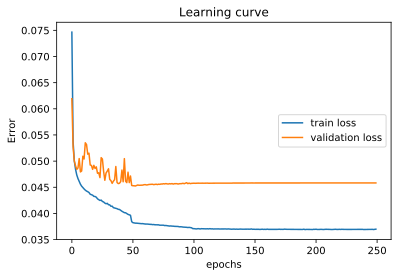

In [28]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [35]:
# Save trained model 
# serialize model to JSON

# manual_variable_initialization(True)
model_json = PetroModel.to_json()
with open("petro_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
PetroModel.save_weights("PetroModel.h5")
print("Saved model to disk")


Saved model to disk


In [19]:
# Load saved model

####### Saved model does not work ######

# load json and create model
json_file = open('petro_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("PetroModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

PetroModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

Loaded model from disk


In [29]:
# Predict training and test data using the trained network
test_output_petro = PetroModel.predict(X_test_petro)
train_output_petro = PetroModel.predict(X_train_petro)

(0, 1)

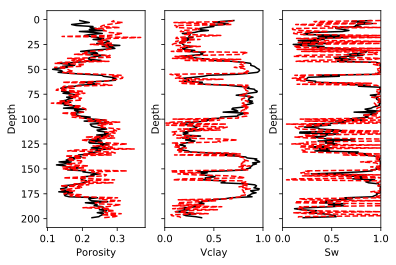

In [24]:
# Checking training data

sample_number = 15
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

axarr[2].plot(train_output_petro[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_train_petro[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

(0, 1)

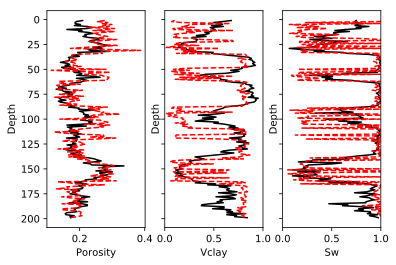

In [25]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

axarr[2].plot(test_output_petro[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_test_petro[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

In [28]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output_petro.shape[0])
Vclay_corr_train = np.zeros(train_output_petro.shape[0])
Sw_corr_train = np.zeros(train_output_petro.shape[0])
for i in range(train_output_petro.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output_petro[i,0,:], Y_train_petro[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output_petro[i,1,:], Y_train_petro[i,1,:])[0,1]
    Sw_corr_train[i] = np.corrcoef(train_output_petro[i,2,:], Y_train_petro[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output_petro.shape[0])
Vclay_corr_test = np.zeros(test_output_petro.shape[0])
Sw_corr_test = np.zeros(test_output_petro.shape[0])
for i in range(test_output_petro.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output_petro[i,0,:], Y_test_petro[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output_petro[i,1,:], Y_test_petro[i,1,:])[0,1]
    Sw_corr_test[i] = np.corrcoef(test_output_petro[i,2,:], Y_test_petro[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_test))
print("Average correlation in Sw for training data = ", np.mean(Sw_corr_test))


Average correlation in porosity for training data =  0.6281928104711794
Average correlation in Vclay for training data =  0.7099799436148162
Average correlation in Sw for training data =  0.6549191969219379
Average correlation in porosity for training data =  0.5486116675742064
Average correlation in Vclay for training data =  0.6580843154387608
Average correlation in Sw for training data =  0.5789339651395491


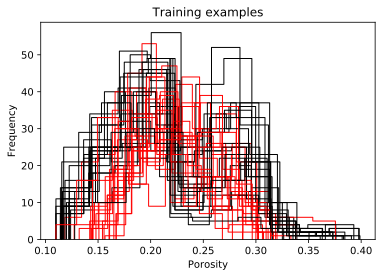

In [29]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,0,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Training examples')



In [30]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,1,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Training examples')

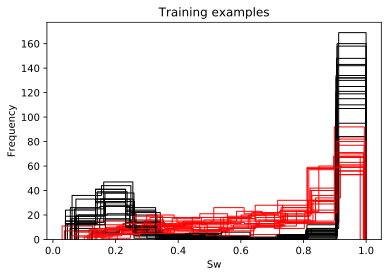

In [31]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,2,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Training examples')

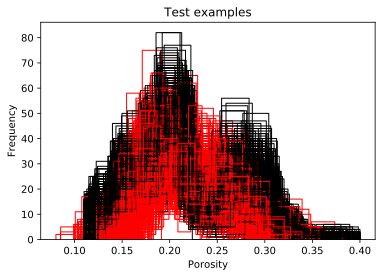

In [32]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,0,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Test examples')

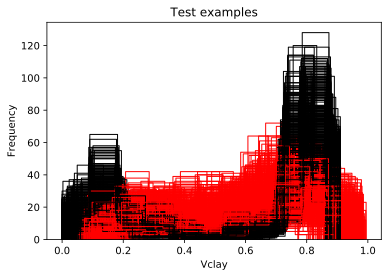

In [33]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,1,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Test examples')

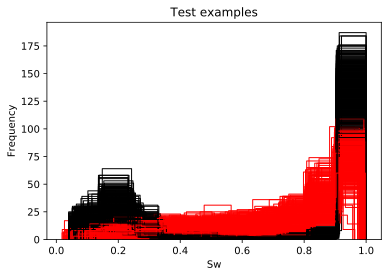

In [34]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,2,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Test examples')

({'var': 0.00931724627556997,
  'len_scale': 810.72645233724,
  'nugget': 0.0005306858990884502},
 array([[1.73614818e+00, 1.51400303e+05, 7.67944124e-05],
        [1.51400303e+05, 1.32028321e+10, 6.70316134e+00],
        [7.67944124e-05, 6.70316134e+00, 7.77963991e-09]]))

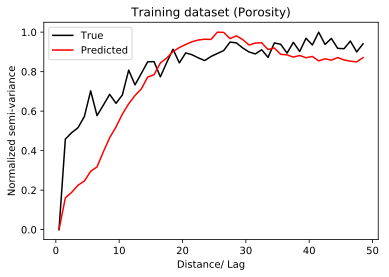

In [49]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.04560365261272794,
  'len_scale': 25.23672992954019,
  'nugget': 1.1942523193626848e-20},
 array([[ 2.37968292e-06, -6.05772819e-04, -2.13170213e-06],
        [-6.05772819e-04,  1.20144347e+00,  9.08294774e-04],
        [-2.13170213e-06,  9.08294774e-04,  2.21150266e-06]]))

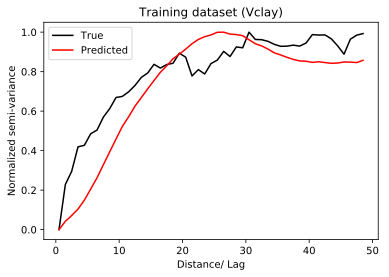

In [50]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.0593260025536004,
  'len_scale': 23.986679039634097,
  'nugget': 1.3718378130964528e-19},
 array([[ 5.56816149e-06, -1.07846236e-03, -5.03637685e-06],
        [-1.07846236e-03,  1.48080141e+00,  1.55345052e-03],
        [-5.03637685e-06,  1.55345052e-03,  5.20831049e-06]]))

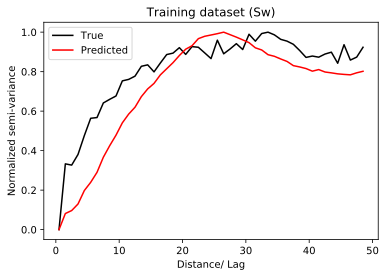

In [51]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [52]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.0019360307019904942,
  'len_scale': 15.627036740198728,
  'nugget': 1.8446584013758363e-18},
 array([[ 4.16828943e-08, -1.94873241e-04, -3.95881301e-08],
        [-1.94873241e-04,  4.08589092e+00,  2.32111236e-04],
        [-3.95881301e-08,  2.32111236e-04,  4.02622291e-08]]))

({'var': 0.07531071756407719,
  'len_scale': 17.514451606757817,
  'nugget': 5.1441241693452575e-18},
 array([[ 1.02522844e-04, -1.33456117e-02, -9.64690398e-05],
        [-1.33456117e-02,  8.46117406e+00,  1.64273991e-02],
        [-9.64690398e-05,  1.64273991e-02,  9.83902072e-05]]))

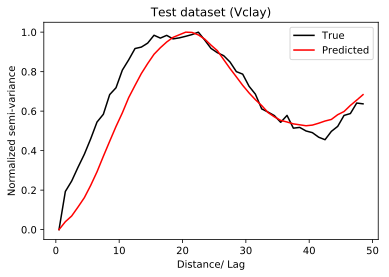

In [53]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.07531071756407719,
  'len_scale': 17.514451606757817,
  'nugget': 5.1441241693452575e-18},
 array([[ 1.02522844e-04, -1.33456117e-02, -9.64690398e-05],
        [-1.33456117e-02,  8.46117406e+00,  1.64273991e-02],
        [-9.64690398e-05,  1.64273991e-02,  9.83902072e-05]]))

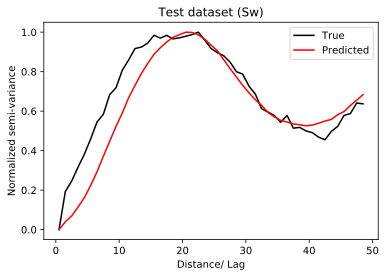

In [54]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 20
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [68]:
# Spectral coherence between true and predicted 
plt.cohere(Y_test_petro[sample_number,1,:], test_output_petro[sample_number,1,:], NFFT=32, Fs=1)

(array([0.98230565, 0.96754584, 0.38982134, 0.29989801, 0.53153651,
        0.4806572 , 0.06428244, 0.15700174, 0.01683727, 0.06743957,
        0.39793461, 0.08345475, 0.30539523, 0.32660757, 0.08783154,
        0.01075749, 0.13454389]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    ]))

array([[  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
      